In [1]:
import tensorflow as tf
import os
import pickle
import numpy as np

In [2]:
CIFAR_DIR = '/home/commaai-03/Data/dataset/cifar-10-python'

def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

In [3]:
filenames = [os.path.join(CIFAR_DIR, file) 
             for file in os.listdir(CIFAR_DIR)
             if '.html' not in file]
filenames.sort()
meta_file = filenames[0]
train_files = filenames[1:-1]
test_file = [filenames[-1]]

In [4]:
_test_data = unpickle(test_file[0])
for k, v in _test_data.items():
    print(k)

b'batch_label'
b'labels'
b'data'
b'filenames'


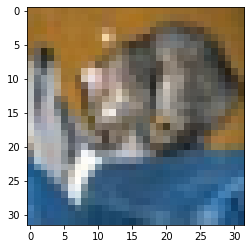

In [5]:
img_arr = _test_data[b'data'][0]
# 32 * 32 * 3 (R,G,B)
img_arr_reshaped = img_arr.reshape((3, 32, 32))
img = img_arr_reshaped.transpose(1, 2, 0)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
imshow(img)

In [6]:
class CifarData:
    
    def __init__(self, filenames, need_shuffle):
        all_data = []
        all_labels = []
        for filename in filenames:
            data, labels = self.load_data(filename)
            all_data.append(data)
            all_labels.append(labels)
        self._data = np.vstack(all_data)
        self._data = self._data / 127.5 - 1
        self._labels = np.hstack(all_labels)
        print('[CIFAR-10]: Data shape-> %s' % str(self._data.shape))
        print('[CIFAR-10]: Label shape-> %s' % str(self._labels.shape))
        
        self.num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
            
    def load_data(self, filename):
        import pickle
        with open(filename, mode='rb') as f:
            data = pickle.load(f, encoding='bytes')
        return data[b'data'], data[b'labels']
    
    def _shuffle_data(self):
        index = np.random.permutation(self.num_examples)
        self._data = self._data[index]
        self._labels = self._labels[index]
        
    def next_batch(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > self.num_examples:
            rest_num_examples = self.num_examples - self._indicator
            data_rest_part = self._data[self._indicator: self.num_examples]
            label_rest_part = self._labels[self._indicator: self.num_examples]
            
            if self._need_shuffle:
                self._shuffle_data()
            # For new loop, self._indicator + batch_size = self.num_examples
            self._indicator = batch_size - rest_num_examples
            end_indicator = self._indicator
            data_new_part = self._data[:end_indicator]
            label_new_part = self._labels[:end_indicator]
            batch_data = np.concatenate((data_rest_part, data_new_part), axis=0)
            batch_label = np.concatenate((label_rest_part, label_new_part), axis=0)
        else:
            batch_data = self._data[self._indicator:end_indicator]
            batch_label = self._labels[self._indicator:end_indicator]
            self._indicator = end_indicator
        
        return batch_data, batch_label

In [7]:
train_data = CifarData(train_files, need_shuffle=True)
test_data = CifarData(test_file, need_shuffle=False)

[CIFAR-10]: Data shape-> (50000, 3072)
[CIFAR-10]: Label shape-> (50000,)
[CIFAR-10]: Data shape-> (10000, 3072)
[CIFAR-10]: Label shape-> (10000,)


In [8]:
x = tf.placeholder(tf.float32, [None, 3072])
y = tf.placeholder(tf.int64, [None])

x_img = tf.reshape(x, [-1, 3, 32, 32])
x_img = tf.transpose(x_img, perm=[0, 2, 3, 1])

class VggNet(tf.keras.Model):
    
    def __init__():
        
        # conv1
        self.conv1_1 = tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3, 3), 
                                 strides=(1,1),
                                 padding='same',
                                 data_format='channels_last',
                                 activation=tf.nn.relu)
        self.conv1_2 = tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3, 3), 
                                 strides=(1,1),
                                 padding='same',
                                 data_format='channels_last',
                                 activation=tf.nn.relu)
        # Max Pooling
        self.maxPooling1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), 
                                                     strides=(2, 2),
                                                     data_format='channels_last')

# conv1: feature_map
conv1_1 = tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3, 3), 
                                 strides=(1,1),
                                 padding='same',
                                 data_format='channels_last',
                                 activation=tf.nn.relu)(x_img)
conv1_2 = tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3, 3), 
                                 strides=(1,1),
                                 padding='same',
                                 data_format='channels_last',
                                 activation=tf.nn.relu)(conv1_1)

# shape: [16, 16]
pooling1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), 
                                     strides=(2, 2),
                                     data_format='channels_last')(conv1_2)

# conv2:
conv2_1 = tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3, 3), 
                                 strides=(1,1),
                                 padding='same',
                                 data_format='channels_last',
                                 activation=tf.nn.relu)(pooling1)
conv2_2 = tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3, 3), 
                                 strides=(1,1),
                                 padding='same',
                                 data_format='channels_last',
                                 activation=tf.nn.relu)(conv2_1)

# pooling
pooling2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), 
                                     strides=(2, 2),
                                     data_format='channels_last')(conv2_2)

# conv3:
conv3_1 = tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3, 3), 
                                 strides=(1,1),
                                 padding='same',
                                 data_format='channels_last',
                                 activation=tf.nn.relu)(pooling2)
conv3_2 = tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3, 3), 
                                 strides=(1,1),
                                 padding='same',
                                 data_format='channels_last',
                                 activation=tf.nn.relu)(conv3_1)

# pooling
pooling3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), 
                                     strides=(2, 2),
                                     data_format='channels_last')(conv3_2)

# flatten
flatten = tf.keras.layers.Flatten(data_format='channels_last')(pooling3)
y_ = tf.keras.layers.Dense(units=10)(flatten)

# loss: tf.losses.sparse_softmax_cross_entropy ->
# tf.nn.reduce_mean(tf.nn.sparse_softma_cross_entropy_with_logits())
_loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

# predict
predict = tf.argmax(y_, 1)
correct_prediction = tf.equal(predict, y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(_loss)

W0920 14:57:05.305756 140611373492032 deprecation.py:506] From /home/commaai-03/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0920 14:57:05.395446 140611373492032 deprecation.py:323] From /home/commaai-03/.local/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
init = tf.global_variables_initializer()
batch_size = 20
train_steps = 10000
test_steps = 2000

with tf.Session() as sess:
    sess.run(init)
    for i in range(train_steps):
        batch_data, batch_labels = train_data.next_batch(batch_size)
        loss, acc, _ = sess.run([_loss, accuracy, train_op], 
                                feed_dict={x: batch_data, y: batch_labels})
        
        if (i+1) % 100 == 0:
            print('[Train]: Step: %d, loss: %4.5f acc: %4.5f' 
                  % (i+1, loss, acc))
        if (i+1) % 1000 == 0:
            all_test_acc_val = []
            for j in range(test_steps):
                test_batch_data, test_batch_labels = test_data.next_batch(batch_size)
                test_acc_val = sess.run([accuracy], 
                                        feed_dict={x: test_batch_data, y: test_batch_labels})
                all_test_acc_val.append(test_acc_val)
            test_acc = np.mean(all_test_acc_val)
            print('[Test] Step: %d, acc: %4.5f' % (i+1, test_acc))

[Train]: Step: 100, loss: 2.04581 acc: 0.30000
[Train]: Step: 200, loss: 1.62394 acc: 0.40000
[Train]: Step: 300, loss: 1.57597 acc: 0.45000
[Train]: Step: 400, loss: 1.33614 acc: 0.50000
[Train]: Step: 500, loss: 1.61541 acc: 0.50000
[Train]: Step: 600, loss: 1.88727 acc: 0.25000
[Train]: Step: 700, loss: 1.30549 acc: 0.50000
[Train]: Step: 800, loss: 1.34295 acc: 0.45000
[Train]: Step: 900, loss: 1.18364 acc: 0.50000
[Train]: Step: 1000, loss: 1.20538 acc: 0.60000
[Test] Step: 1000, acc: 0.50150
[Train]: Step: 1100, loss: 1.49936 acc: 0.50000
[Train]: Step: 1200, loss: 1.33192 acc: 0.60000
[Train]: Step: 1300, loss: 1.40546 acc: 0.55000
[Train]: Step: 1400, loss: 1.39623 acc: 0.50000
[Train]: Step: 1500, loss: 1.60176 acc: 0.45000
[Train]: Step: 1600, loss: 1.19743 acc: 0.60000
[Train]: Step: 1700, loss: 1.23713 acc: 0.55000
[Train]: Step: 1800, loss: 1.32455 acc: 0.55000
[Train]: Step: 1900, loss: 1.48543 acc: 0.40000
[Train]: Step: 2000, loss: 1.12587 acc: 0.75000
[Test] Step: 2000